In [1]:
import pathlib
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


pd.plotting.register_matplotlib_converters()
data_path = pathlib.Path("..\\data")

# Read data

In [2]:
root = ET.parse(data_path / "Half-Life_-_WON_Easy.lss").getroot()

In [3]:
runs = (
    pd.DataFrame(
        data=[element.attrib for element in root.find("AttemptHistory").findall("Attempt")]
    )
    .astype({"id": int, "isStartedSynced": bool, "isEndedSynced": bool})
)
runs.loc[:, "started"] = pd.to_datetime(runs.loc[:, "started"])
runs.loc[:, "ended"] = pd.to_datetime(runs.loc[:, "ended"])
runs.head()

,id,started,isStartedSynced,ended,isEndedSynced
0,1,2018-01-17 17:45:30,True,2018-01-17 17:45:38,True
1,2,2018-01-17 17:45:38,True,2018-01-17 17:46:11,True
2,3,2018-01-17 17:46:11,True,2018-01-17 17:47:00,True
3,4,2018-01-17 17:47:05,True,2018-01-17 17:48:11,True
4,5,2018-01-17 17:48:11,True,2018-01-17 17:48:21,True


In [4]:
segments = []
for segment in root.find("Segments").findall("Segment"):
    name = segment.find("Name").text
    for segment_time in segment.find("SegmentHistory").findall("Time"):
        try:
            real_time = pd.to_timedelta(segment_time.find("RealTime").text)
        except AttributeError:
            real_time = np.nan
        try:
            game_time = pd.to_timedelta(segment_time.find("GameTime").text)
        except AttributeError:
            game_time = np.nan
        segments.append(
            {
                "Name": name,
                "id": int(segment_time.attrib["id"]),
                "RealTime": real_time,
                "GameTime": game_time
            }
        )
segments = pd.DataFrame(data=segments)
segments.loc[:, "Name"] = segments.loc[:, "Name"].apply(lambda x: " ".join([val for val in x.lower().split(" ") if len(val) > 0]))
segments.loc[:, "Name"] = pd.Categorical(
    segments.loc[:, "Name"],
    [
        'anomalous materials',
        'unforeseen consequences',
        'office complex',
        '"we\'ve got hostiles"',
        'blast pit',
        'power up',
        'on a rail',
        'apprehension',
        'residue processing',
        'questionable ethics',
        'surface tension',
        '"forget about freeman!"',
        'lambda core',
        'xen',
        "gonarch's lair",
        'interloper',
        'nihilanth'
    ]
)
segments = segments.merge(right=runs, how="inner", on="id").dropna()
segments.head()

,Name,id,RealTime,GameTime,started,isStartedSynced,ended,isEndedSynced
0,anomalous materials,700,00:04:29.376000,00:04:22.567000,2018-02-24 19:54:08,True,2018-02-24 20:39:29,True
1,office complex,700,00:01:18.780000,00:01:17.620000,2018-02-24 19:54:08,True,2018-02-24 20:39:29,True
2,"""we've got hostiles""",700,00:00:17.677000,00:00:16.714000,2018-02-24 19:54:08,True,2018-02-24 20:39:29,True
3,anomalous materials,699,00:04:14.128000,00:04:11.970000,2018-02-24 19:43:25,True,2018-02-24 19:54:08,True
4,office complex,699,00:01:14.105000,00:01:12.081000,2018-02-24 19:43:25,True,2018-02-24 19:54:08,True


# Get statistics by segment

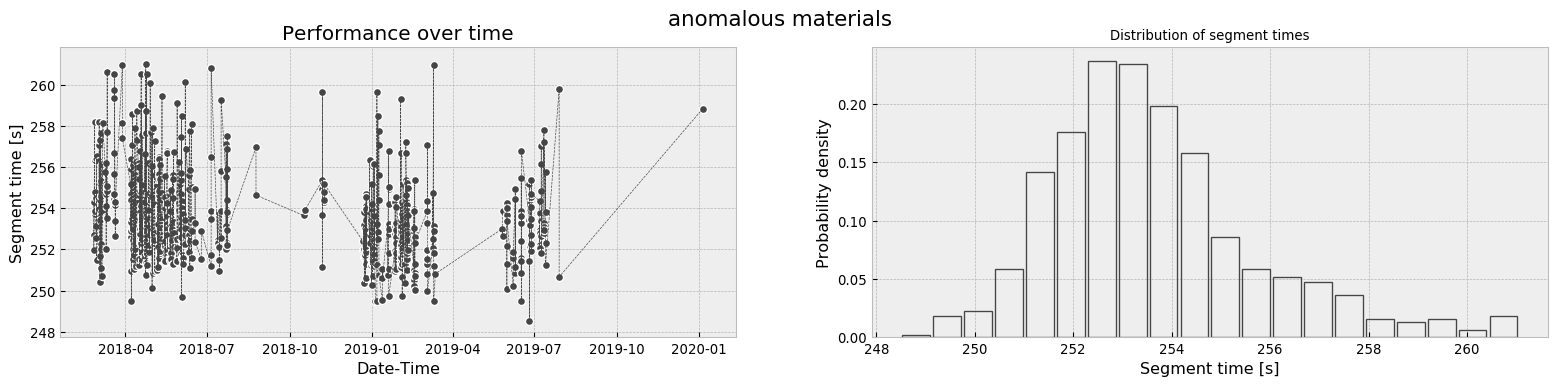

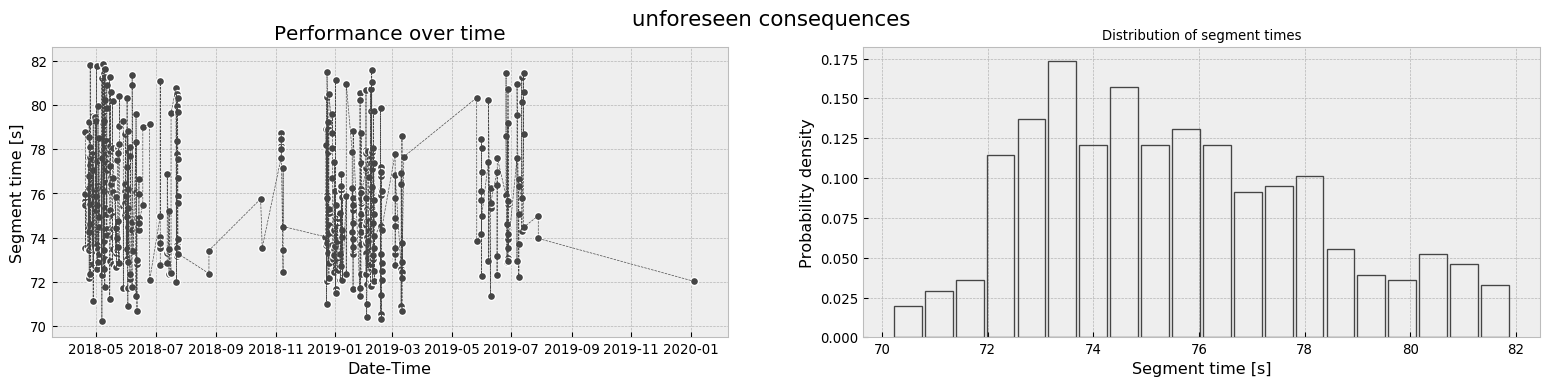

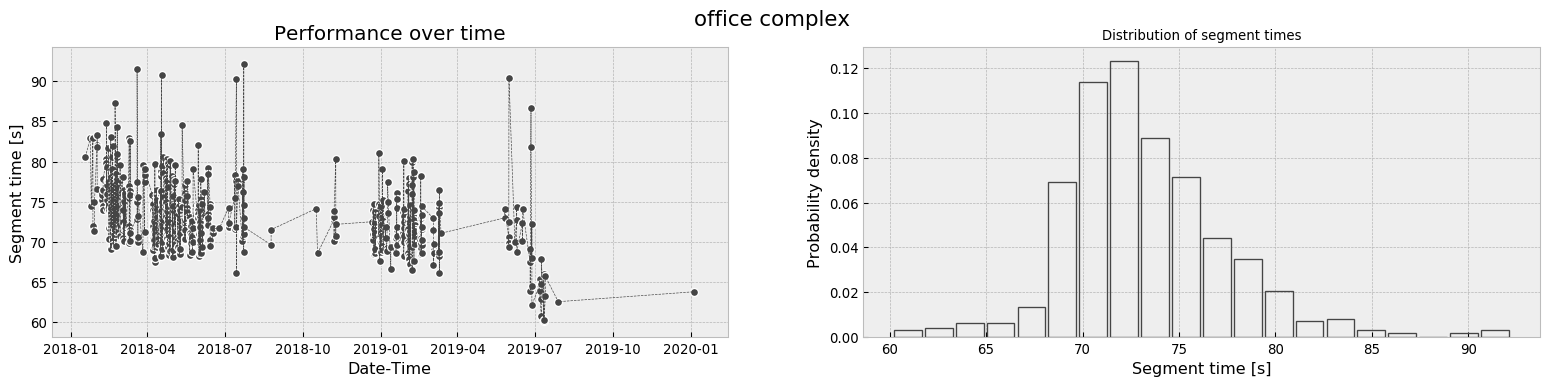

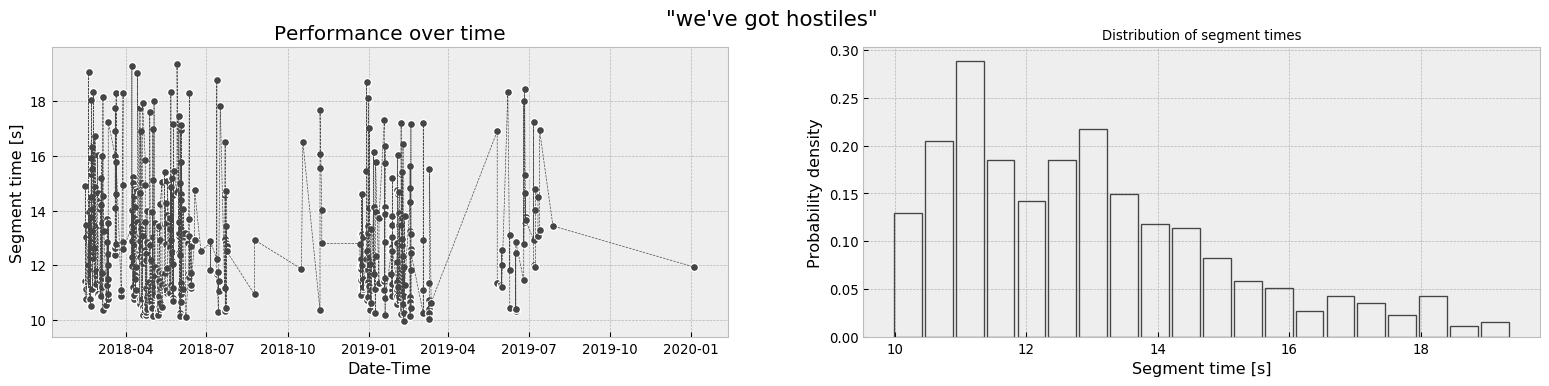

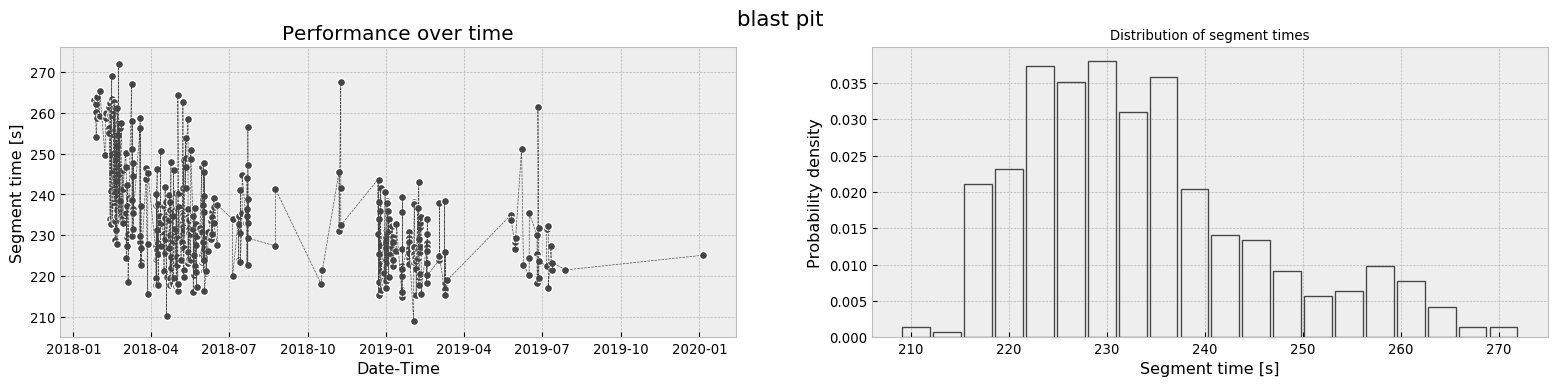

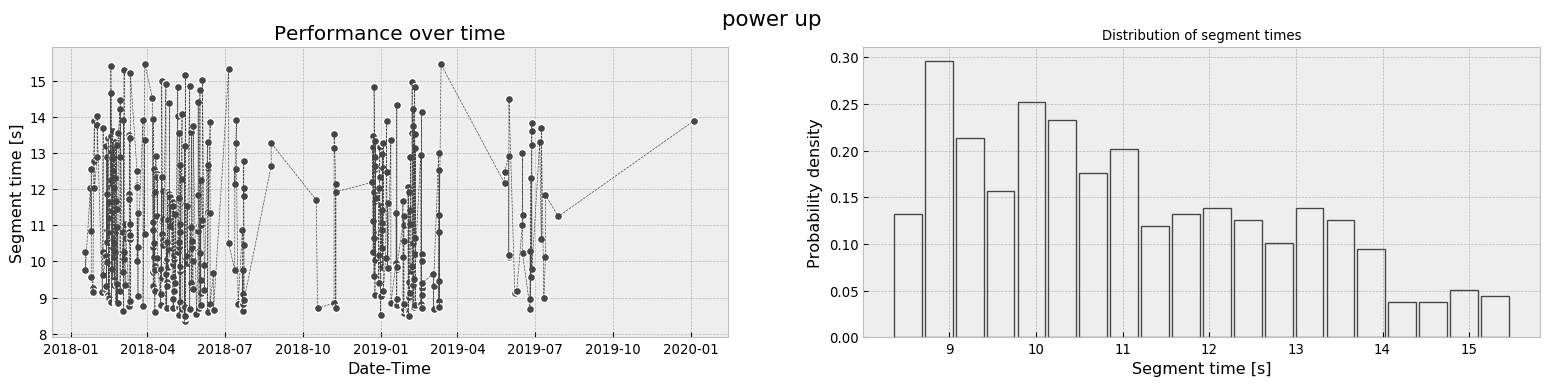

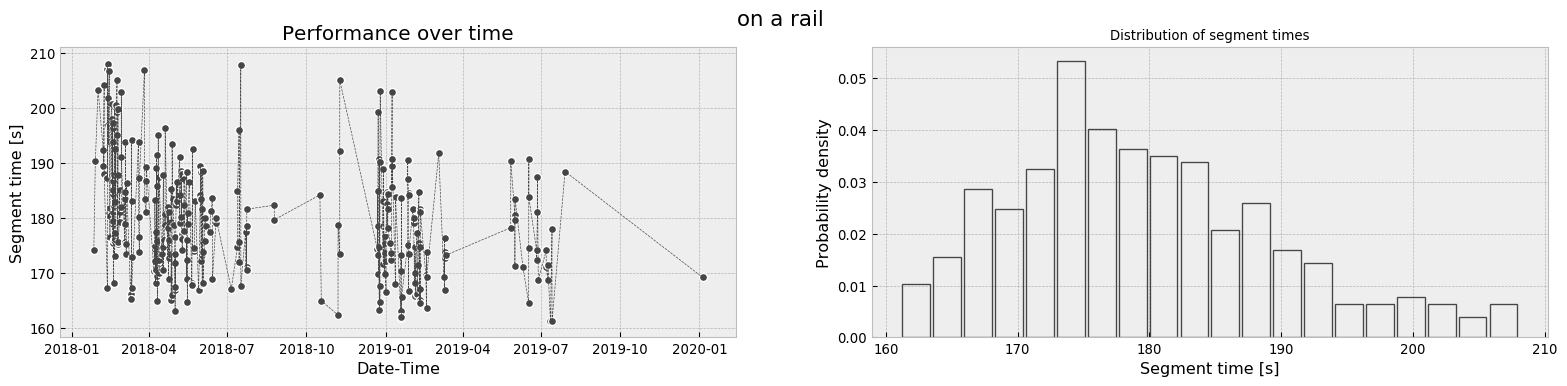

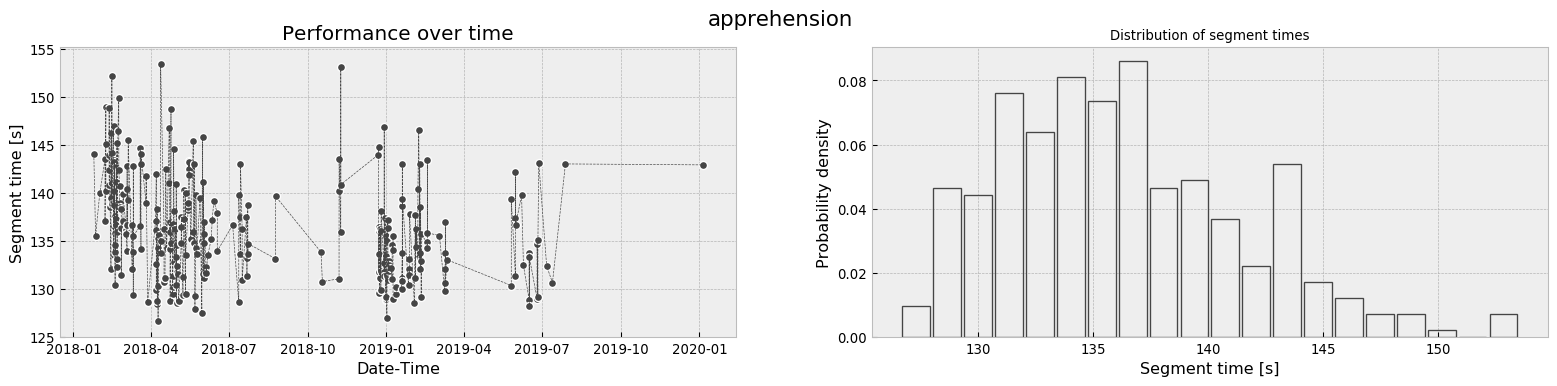

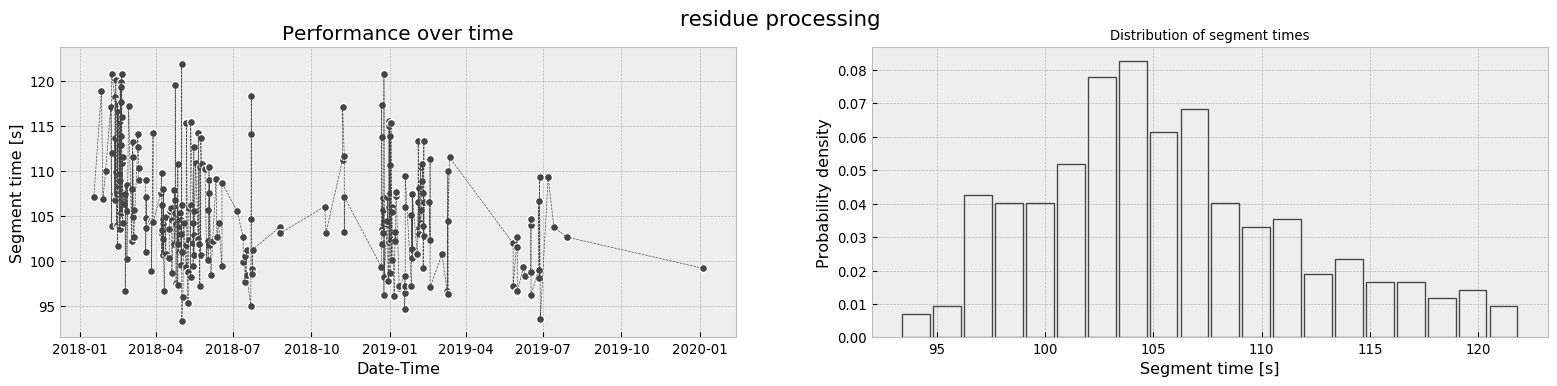

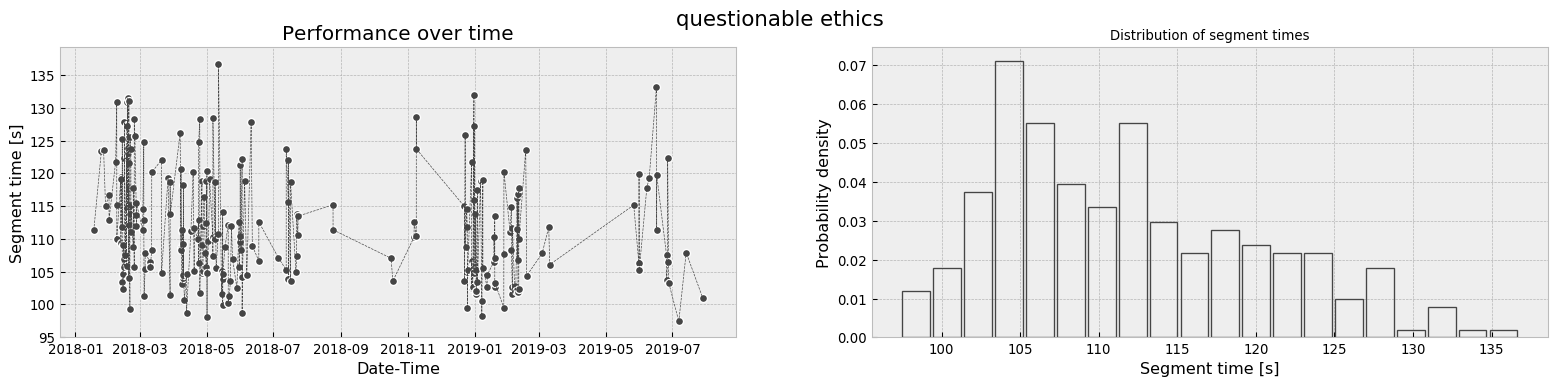

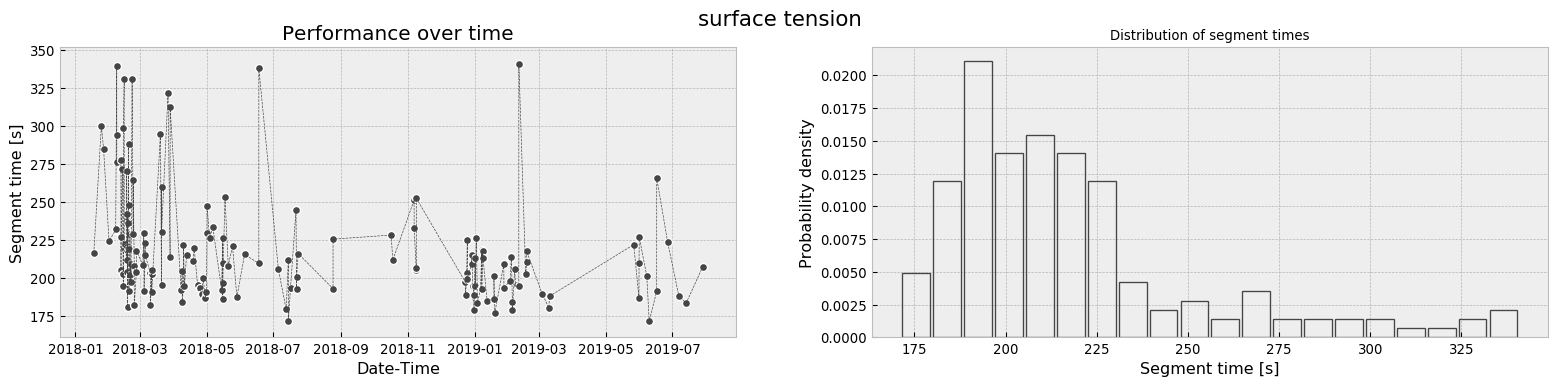

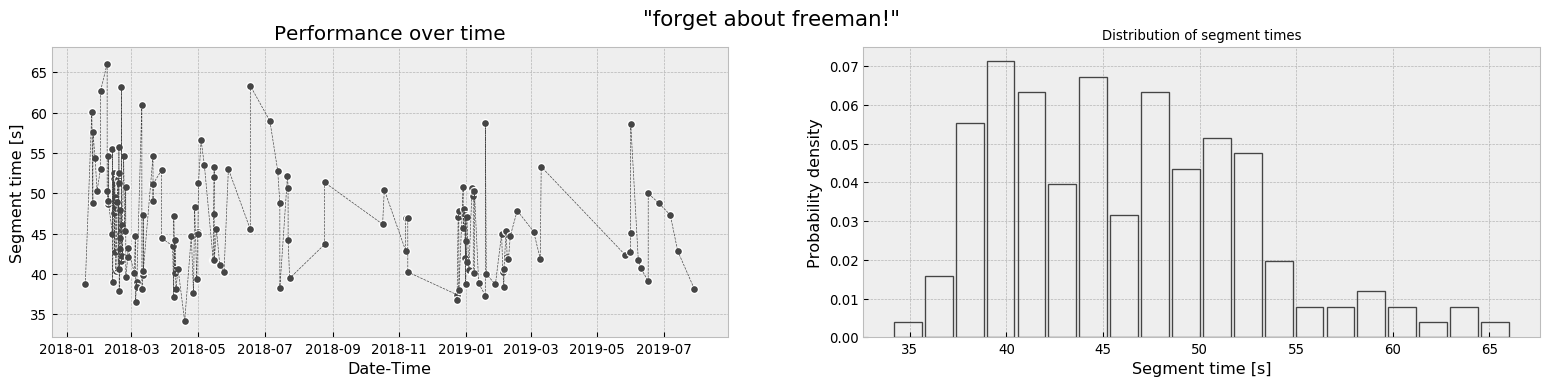

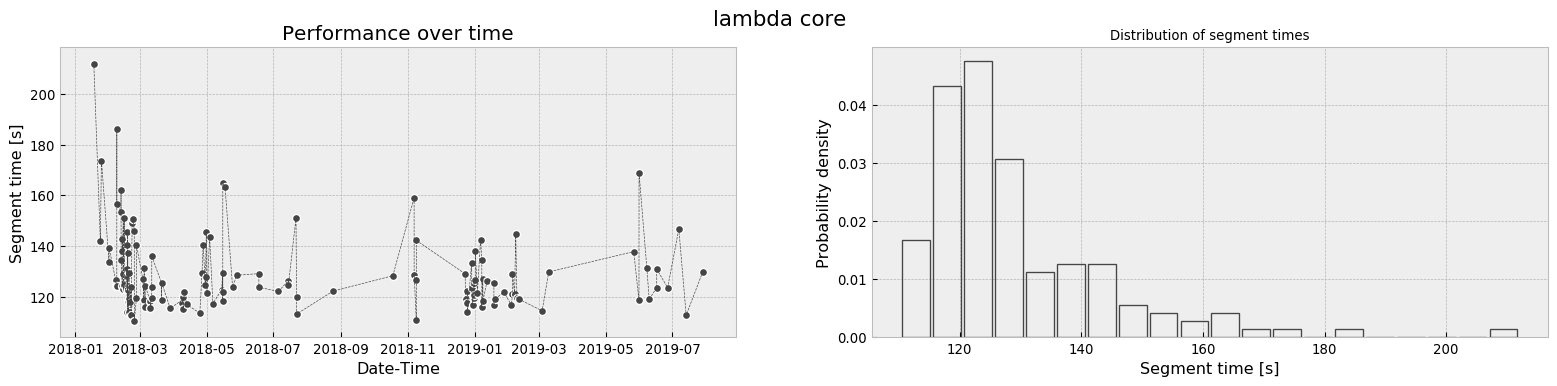

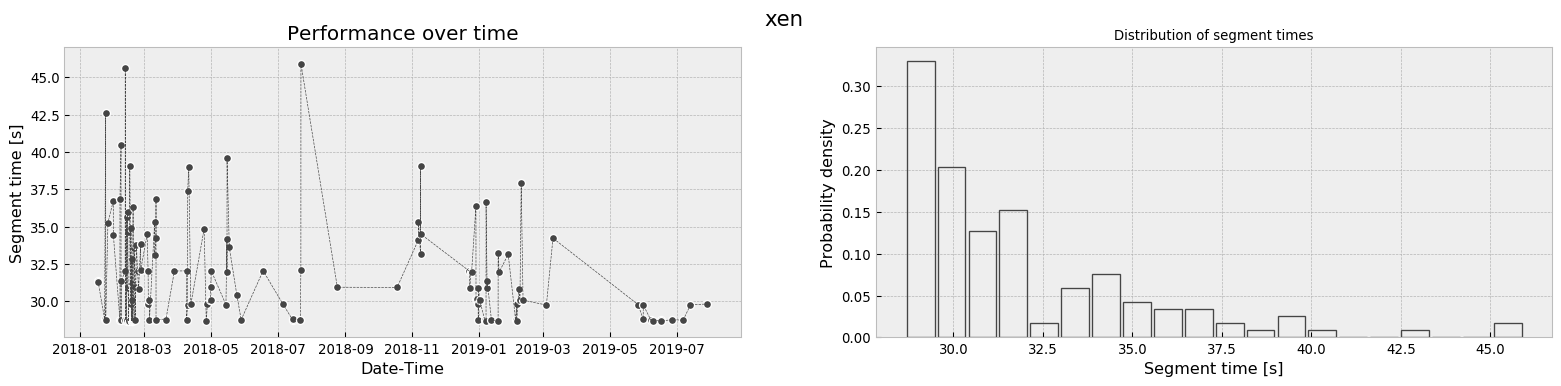

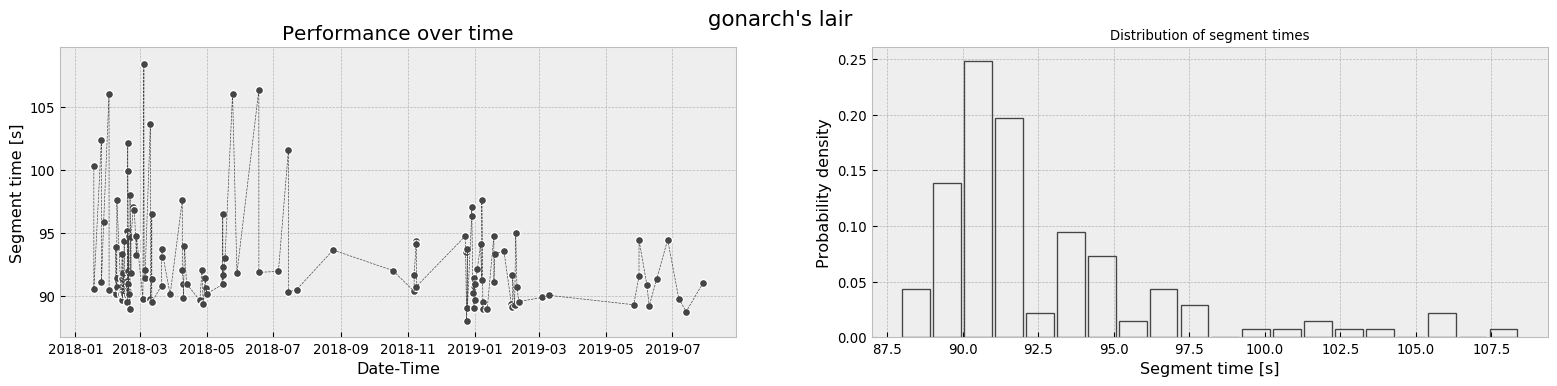

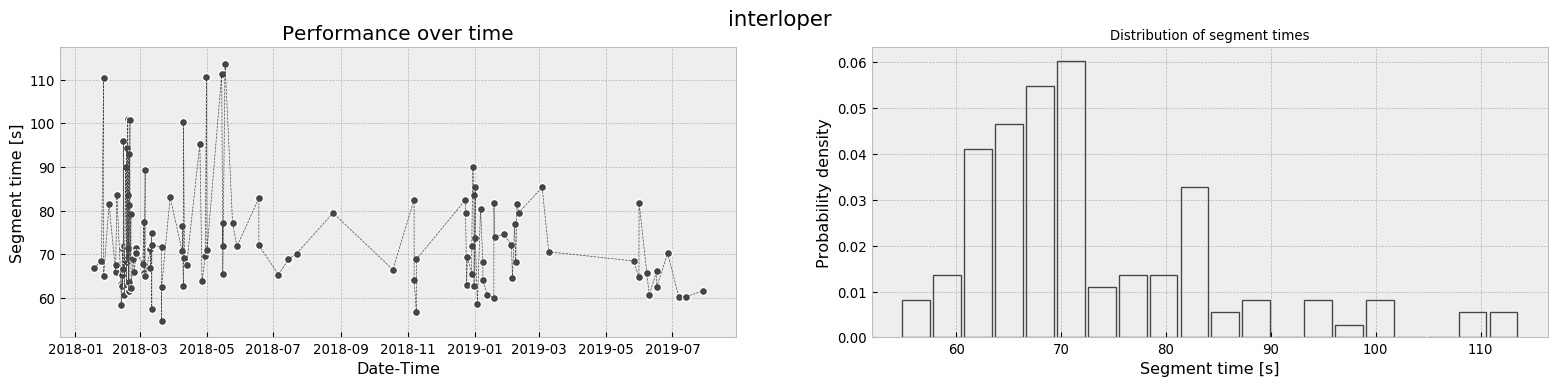

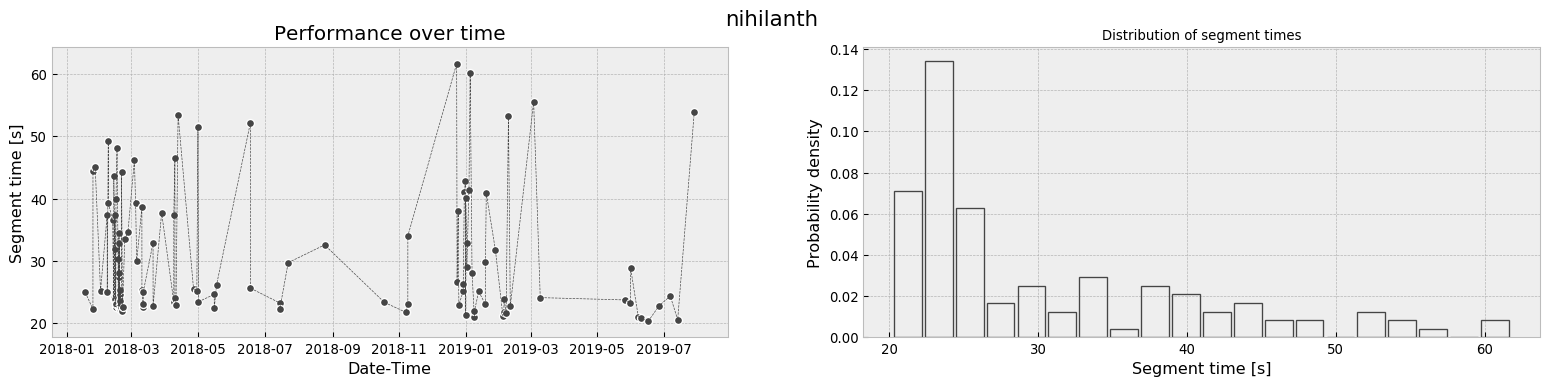

In [5]:
for segment, df in segments.groupby("Name", sort=True):
    df_sorted = df.copy(deep=True).sort_values("started")
    df_sorted = df_sorted.loc[df_sorted.loc[:, "GameTime"] <= np.quantile(df_sorted.loc[:, "GameTime"], 0.95)]
    with plt.style.context("bmh"):
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 4), dpi=96)

        ax1.plot(
            df_sorted.loc[:, "started"], df_sorted.loc[:, "GameTime"].astype(np.timedelta64).astype(float) / 1e9,
            color="#454545", ls="--", lw=.5, zorder=10
        )
        ax1.scatter(
            df_sorted.loc[:, "started"], df_sorted.loc[:, "GameTime"].astype(np.timedelta64).astype(float) / 1e9,
            marker="o", facecolor="#454545", edgecolor="w", lw=1, zorder=10
        )
        ax1.set_title("Performance over time", fontsize=15)
        ax1.set_xlabel("Date-Time")
        ax1.set_ylabel("Segment time [s]")

        ax2.hist(
            df_sorted.loc[:, "GameTime"].astype(np.timedelta64).astype(float) / 1e9,
            bins=20, density=True, rwidth=0.9, facecolor="None", edgecolor="#454545", lw=1, ls="-", zorder=10
        )
        ax2.set_title("Distribution of segment times", fontsize=10)
        ax2.set_xlabel("Segment time [s]")
        ax2.set_ylabel("Probability density")

        fig.suptitle(f"{segment}", fontsize=16)

# Optimization of pace
Get distribution of total run times given current pace and segment. Provides information required to make decision whether to continue run or not.